## Cosmological constraints with BAO
I provide you with a series of power spectrum measurements, at effective redshifts $z_{\mathrm{zeff}}$ = 0.1 to 1.9.
In this session, you will:

1) measure the BAO isotropic parameter $\alpha(z_{\mathrm{eff}}) = \left[D_{V}(z_{\mathrm{eff}})/r_{\mathrm{drag}}\right] / \left[D_{V}^{\mathrm{fid}}(z_{\mathrm{eff}})/r_{\mathrm{drag}}^{\mathrm{fid}}\right]$ of each of the measurements

2) with these measurements, you will constrain $\Omega_{m}, \Omega_{k}$ (hence detect dark energy!)

3) provided a value of $r_{\mathrm{drag}}$ (in $\mathrm{Mpc}$), you will perform an "inverse distance ladder" analysis: fit all the $\alpha(z_{\mathrm{eff}})$ by varying $H_{0}$ and $\Omega_{m}$

4) those finding the correct $\Omega_{m}$, $\Omega_{k}$ and $H_{0}$ (I know the truth, you don't!) win!

5) do you remember how to compute the correlation function? (last year's TD) What about the power spectrum? If any question, please ask!

### A look at power spectrum measurements

At effective redshift 0.10 first k are [0.007493 0.016066], pk0 [42909.9873932  59776.57621662]
At effective redshift 0.30 first k are [0.007493 0.016066], pk0 [57489.32855311 64358.16927932]
At effective redshift 0.50 first k are [0.007493 0.016066], pk0 [27859.8106431  56494.74882465]
At effective redshift 0.70 first k are [0.007493 0.016066], pk0 [36292.03334245 63477.33562078]
At effective redshift 0.90 first k are [0.007493 0.016066], pk0 [49376.93906151 61493.77281776]
At effective redshift 1.10 first k are [0.007493 0.016066], pk0 [48190.65682782 53830.05686714]
At effective redshift 1.30 first k are [0.007493 0.016066], pk0 [33941.41707941 54446.38458601]
At effective redshift 1.50 first k are [0.007493 0.016066], pk0 [55992.63482905 64889.76768663]
At effective redshift 1.70 first k are [0.007493 0.016066], pk0 [45874.92696741 54566.6671169 ]
At effective redshift 1.90 first k are [0.007493 0.016066], pk0 [41032.90084511 50980.66473723]


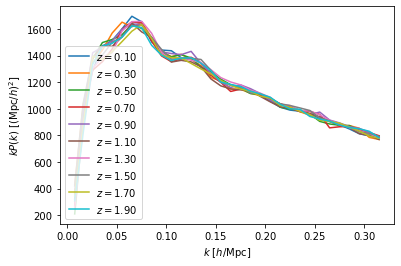

Attributes {'space': 'power', 'tracer': 'LRGpCMASS', 'zeff': 1.9000000000000001, 'recon': False, 'ells': [0, 2, 4]}


In [1]:
import numpy as np
from matplotlib import pyplot as plt

from environment import Measurement, list_path_sim_measurement  # specify paths

list_path = list_path_sim_measurement()
list_data = []

for path in list_path:
    m = Measurement.load(path)
    print('At effective redshift {:.2f} first k are {}, pk0 {}'.format(m.attrs['zeff'], m.x[:2], m.y[0,:2]))
    plt.plot(m.x, m.x * m.y[0], label='$z = {:.2f}$'.format(m.attrs['zeff']))
    list_data.append(m)

plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()
# m is an instance of Measurement
# k (wavenumber) array is m.x
# pk (power spectrum) is m.y
# m.y is of shape (1, len(m.x)): the first Legendre multipole (monopole).
print('Attributes', m.attrs)

### Isotropic BAO power spectrum model

The principle of BAO fits is to measure *only* the position of the BAO, marginalizing over the shape of the power spectrum, for this measurement to be robust to distortions due to observational systematics.
For this we decompose the fiducial power spectrum into *wiggle* and *no-wiggle* parts. We will allow the *wiggle* part to move, keeping the *no-wiggle* part fixed, adding a polynomial in $k$ (*broadband terms*) to adjust the shape of the data power spectrum.

In [2]:
# First generate a linear power spectrum in $(\mathrm{Mpc}/h)^{3}$ units; z = 0 is enough.
# (Indeed, linear growth factor D^{2}(z) is degenerate with B^2 in the model below)
# Fiducial cosmological parameters are:
# dict(Omega_m=0.31, Omega_b=0.022/0.676**2, h=0.676, sigma8=0.8, n_s=0.97)
# Several options:
# 1) use cosmoprimo (engine='class' or engine='camb'), see https://github.com/cosmodesi/cosmoprimo/blob/main/nb/examples.ipynb
from cosmoprimo import Cosmology
cosmo_fid = Cosmology(Omega_m=0.31, omega_b=0.022, h=0.676, sigma8=0.8, n_s=0.97, engine='class')
klin = np.geomspace(1e-4, 5., 2000)
pk_interpolator = cosmo_fid.get_fourier().pk_interpolator().to_1d(z=0.)
pklin = pk_interpolator(klin)
#np.savetxt('pklin.txt', np.column_stack([klin, pklin]))
# 2) use classy, camb...
# 3) load precomputed linear power spectrum:
#klin, pklin = np.loadtxt('pklin.txt', unpack=True)

In [3]:
# Then you need a smooth power spectrum, matching the linear power spectrum but without BAO wiggles.
# Several options:
# 1) use cosmoprimo
from cosmoprimo import PowerSpectrumInterpolator1D
pk_interpolator = PowerSpectrumInterpolator1D(klin, pklin, extrap_kmin=1e-4, extrap_kmax=1e2)
from cosmoprimo import PowerSpectrumBAOFilter
pknow = PowerSpectrumBAOFilter(pk_interpolator, engine='wallish2018').smooth_pk_interpolator()(klin)
# 2) fit the linear power spectrum in log/log with a polynomial (Hinton2017)
#logk = np.log(klin)
#logpk = np.log(pklin)
#maxk = logk[pklin.argmax()]
#gauss = np.exp(-0.5 * ((logk - maxk) / 1.)**2)
#w = np.ones_like(klin) - 0.5 * gauss
#series = np.polynomial.polynomial.Polynomial.fit(logk, logpk, deg=13 ,w=w)
#pknow = np.exp(series(logk))
# np.polynomial.polynomial.Polynomial.fit(logk, logpk, degree=13, w=w)

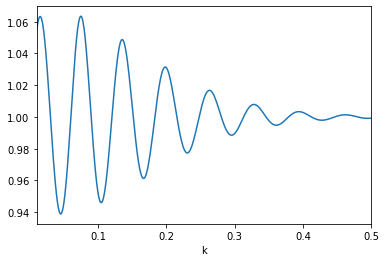

In [4]:
# Plot wiggles = linear power spectrum / no-wiggle power spectrum
wiggles = pklin / pknow
plt.plot(klin, wiggles)
plt.xlim(1e-2,0.5)
plt.xlabel('k')
plt.show()

Model equation is (https://arxiv.org/abs/1705.06373, but many other formulations exist):
$P(k,\alpha) = B^{2} [P_{\mathrm{nw}}(k) + \sum_{i=0}^{2} A_{i} k^{i}] \lbrace 1 + [\mathcal{O}(k/\alpha) - 1] e^{- \frac{1}{2} \Sigma_{\mathrm{nl}}^{2}k^{2}} \rbrace$  
$P_{\mathrm{nw}}$ is the no-wiggle power spectrum.  
$\mathcal{O}(k) = P_{\mathrm{lin}}(k)/P_{\mathrm{nw}}(k)$ are the wiggles.  
Free parameters are: $\alpha, B, A_{i}$, parameter of cosmological interest is $\alpha$ (which shifts BAO wiggles).
Choose for the non-linear damping of BAO wiggles $\Sigma_{\mathrm{nl}} = 6.7\;\mathrm{Mpc/h}$.

In [5]:
sigmanl = 6.7

def pk_iso(k, alpha, B, A0, A1, A2, A3=0):
    """Code here BAO power spectrum model"""
    ipknow = np.interp(k, klin, pknow)
    poly = A0 + A1 * k + A2 * k**2 + A3 / k
    damped_wiggles = 1 + (np.interp(k / alpha, klin, wiggles) - 1) * np.exp(-1. / 2. * sigmanl**2 * k**2)
    return B**2 * (ipknow + poly) * damped_wiggles

### Model fitting
Repeat, for each redshift z:  
- build $\chi^{2} = (\mathrm{data} - \mathrm{model})^T C^{-1} (\mathrm{data} - \mathrm{model})$
- minimize chi2 for example with scipy.optimize.minimize, and check the fit looks good by plotting data and best fit model

Reduced chi2 is 24.6100/(32 - 5) = 0.9115


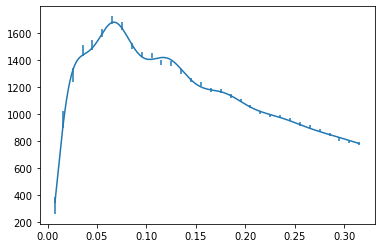

Reduced chi2 is 46.2799/(32 - 5) = 1.7141


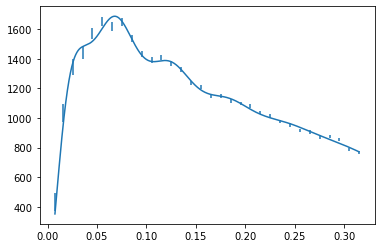

Reduced chi2 is 38.2322/(32 - 5) = 1.4160


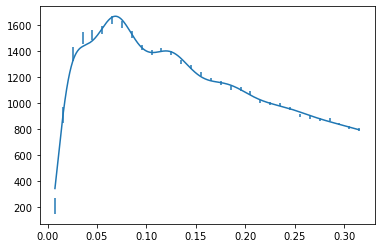

Reduced chi2 is 61.6208/(32 - 5) = 2.2823


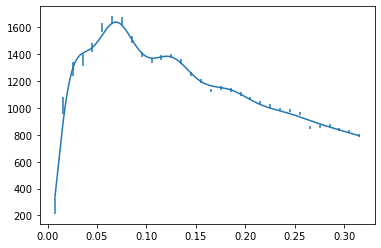

Reduced chi2 is 27.4280/(32 - 5) = 1.0159


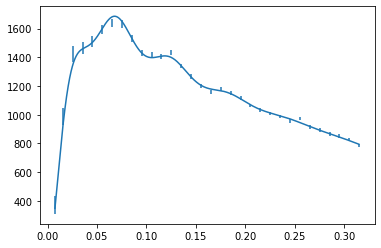

Reduced chi2 is 18.8746/(32 - 5) = 0.6991


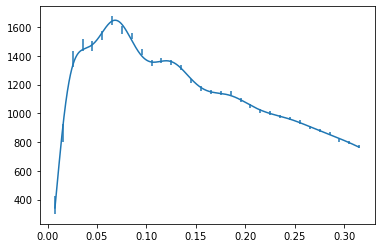

Reduced chi2 is 24.5909/(32 - 5) = 0.9108


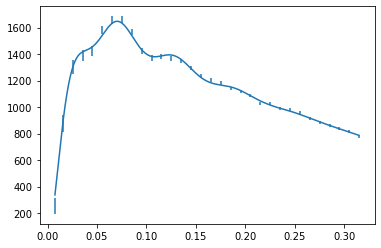

Reduced chi2 is 31.1602/(32 - 5) = 1.1541


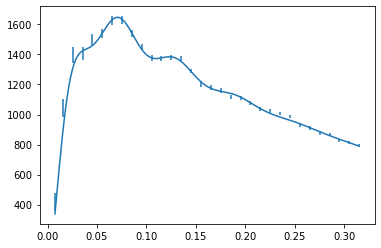

Reduced chi2 is 32.1060/(32 - 5) = 1.1891


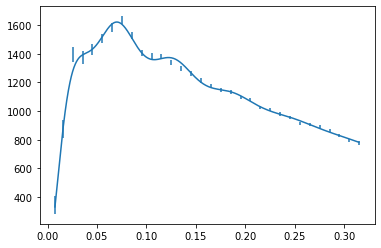

Reduced chi2 is 29.3235/(32 - 5) = 1.0861


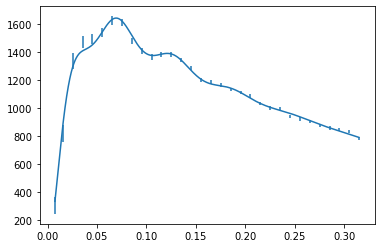

In [6]:
from scipy import optimize

nbb = 3
init = [1., 2.] + [0.]*nbb  # alpha, B, broadbands
bounds = [(0.88, 1.12), (1., 5.)] + [(-5e4, 5e4)]*nbb

for m in list_data:
    covariance = m.cov
    invcovariance = np.linalg.inv(covariance)
    k = m.x
    data = m.y[0]
    
    def chi2(args):
        model = pk_iso(k,*args)
        diff = data - model
        toret = diff.T.dot(invcovariance).dot(diff)
        return toret
    
    result = optimize.minimize(chi2, init, method='SLSQP', bounds=bounds)
    args = result.x
    minchi2 = chi2(args)
    msg = 'Reduced chi2 is {:.4f}/({:d} - {:d}) = {:.4f}'.format(minchi2, len(k), len(args), minchi2 / (len(k) - len(args)))
    print(msg)
    kplt = klin[(klin > k[0]) & (klin < k[-1])]
    """Make plot of data, model, error bars"""
    plt.errorbar(k, k * data, k * np.diag(covariance) ** 0.5, linestyle='none', color='C0')
    plt.plot(kplt, kplt * pk_iso(kplt, *args), label='model', color='C0')
    plt.show()

We want an error on our alpha measurement. Either:
- likelihood profiling: repeat the above for alpha values in e.g. [0.9, 1.1], and take errors at $\chi_{\mathrm{min}}^{2} + 1$
- likelihood sampling: use sampler, e.g. https://github.com/dfm/emcee

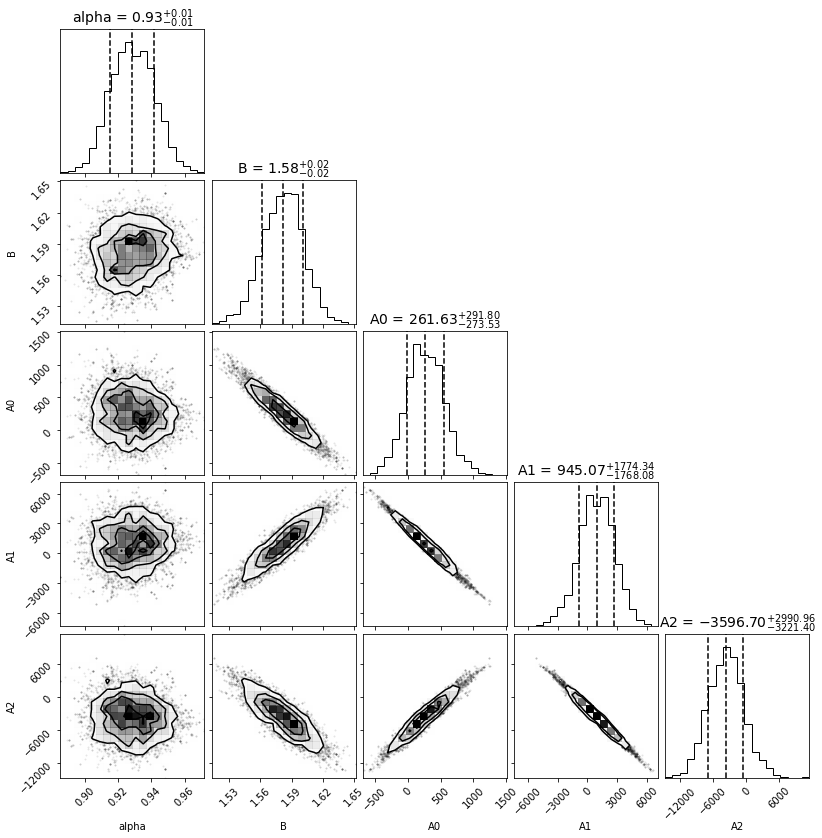

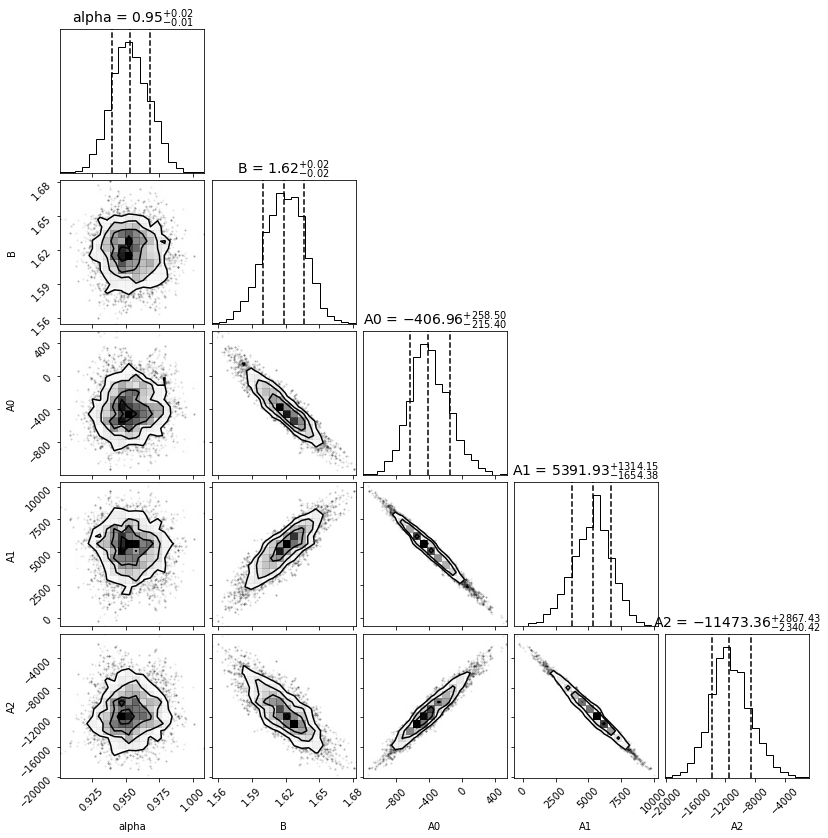

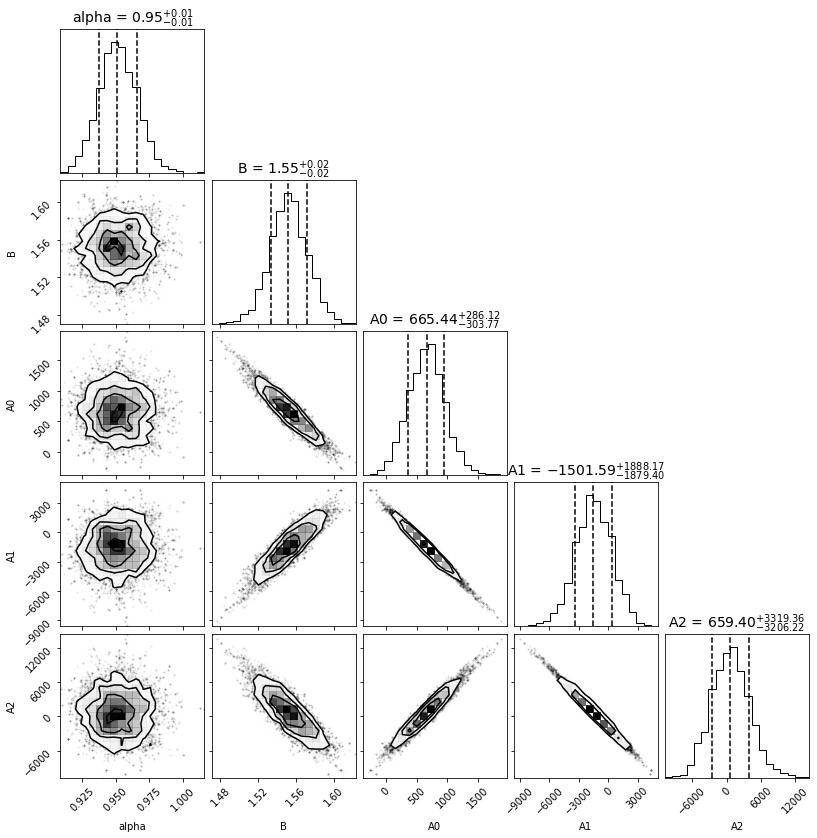

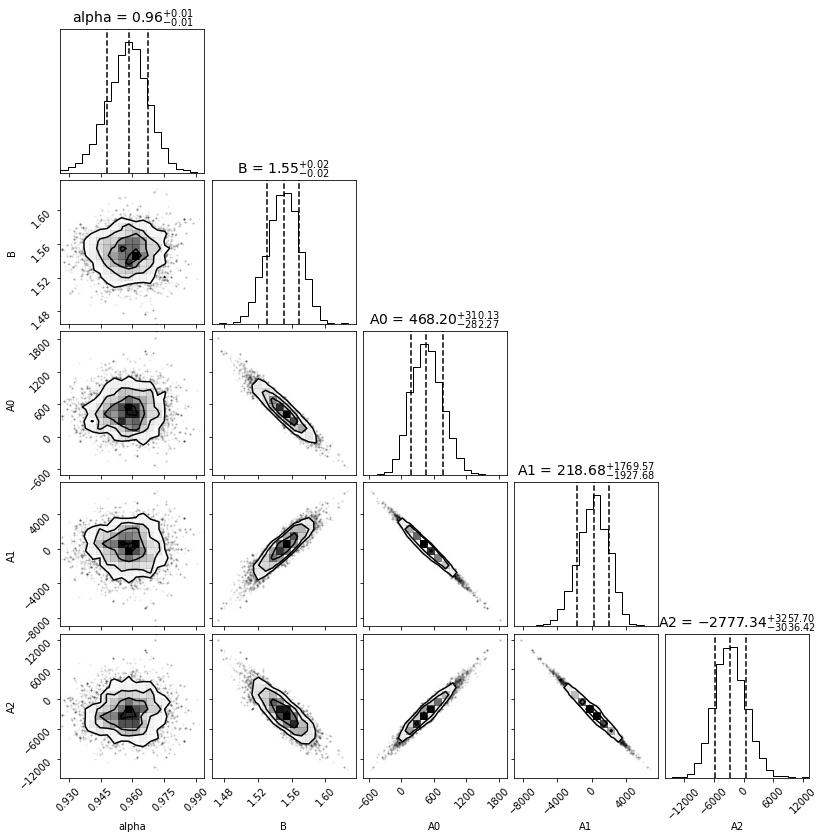

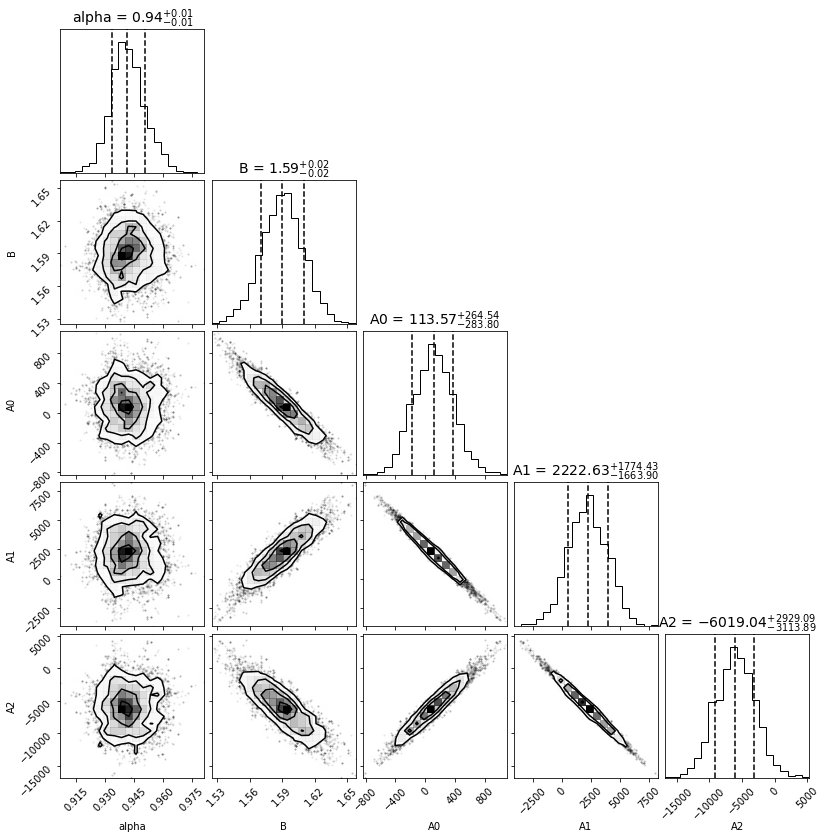

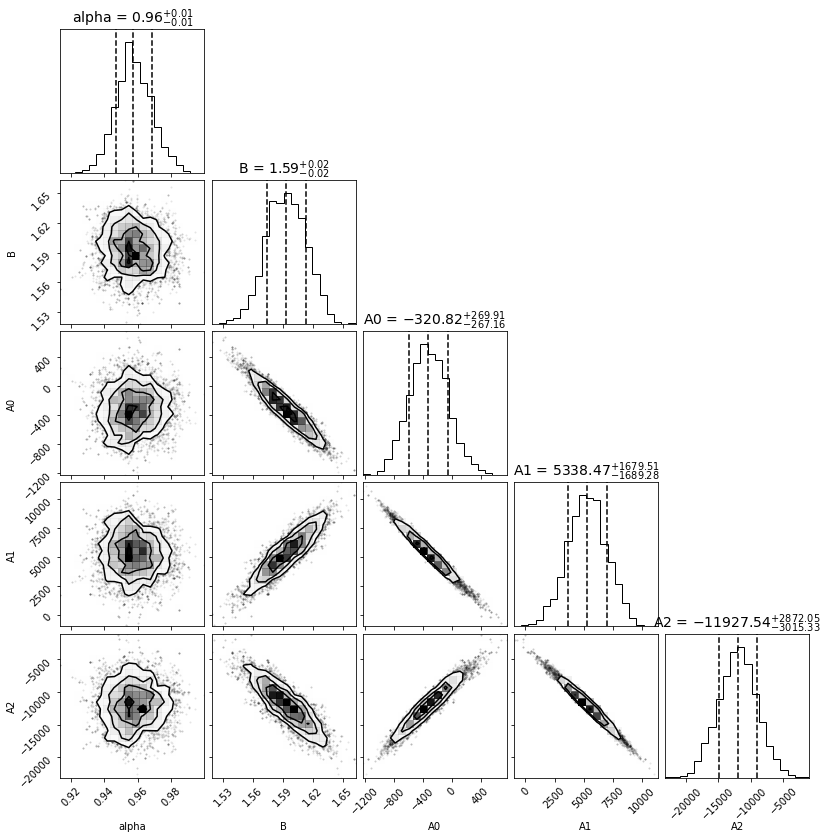

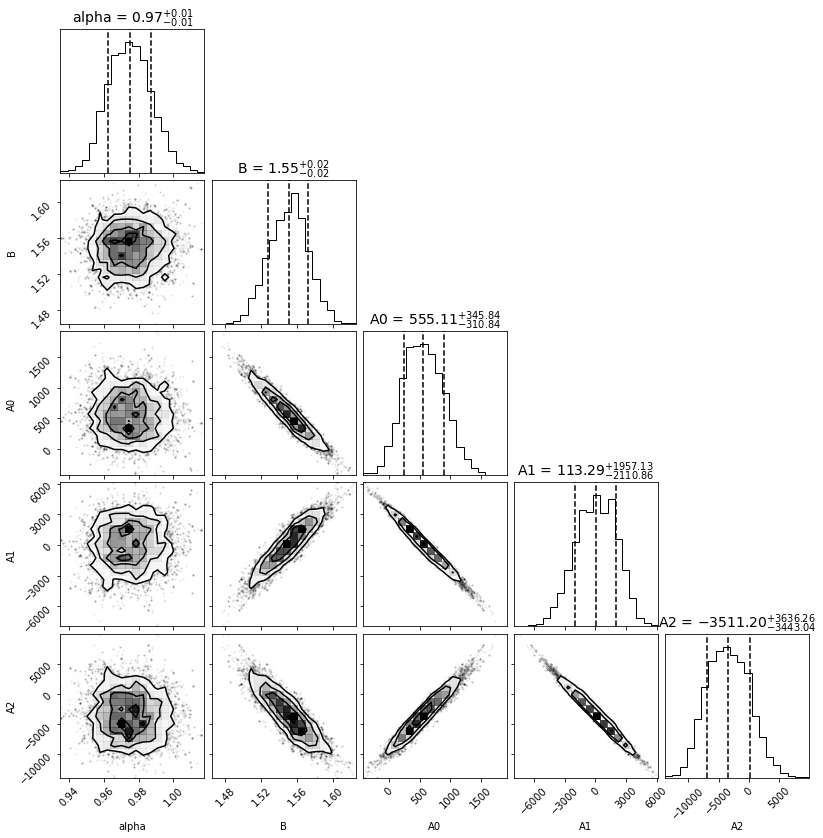

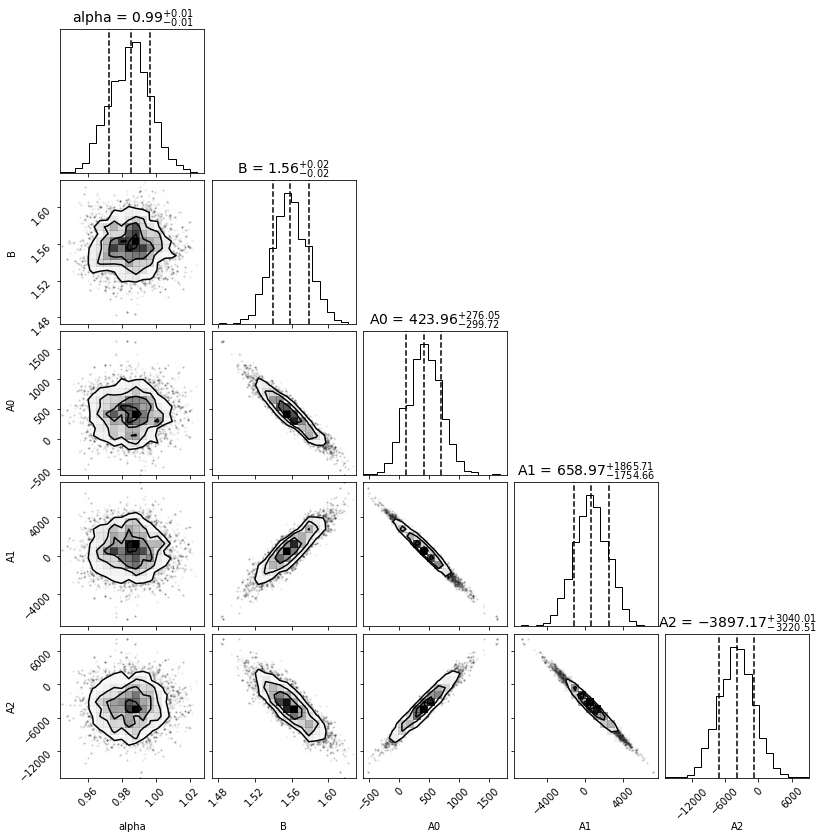

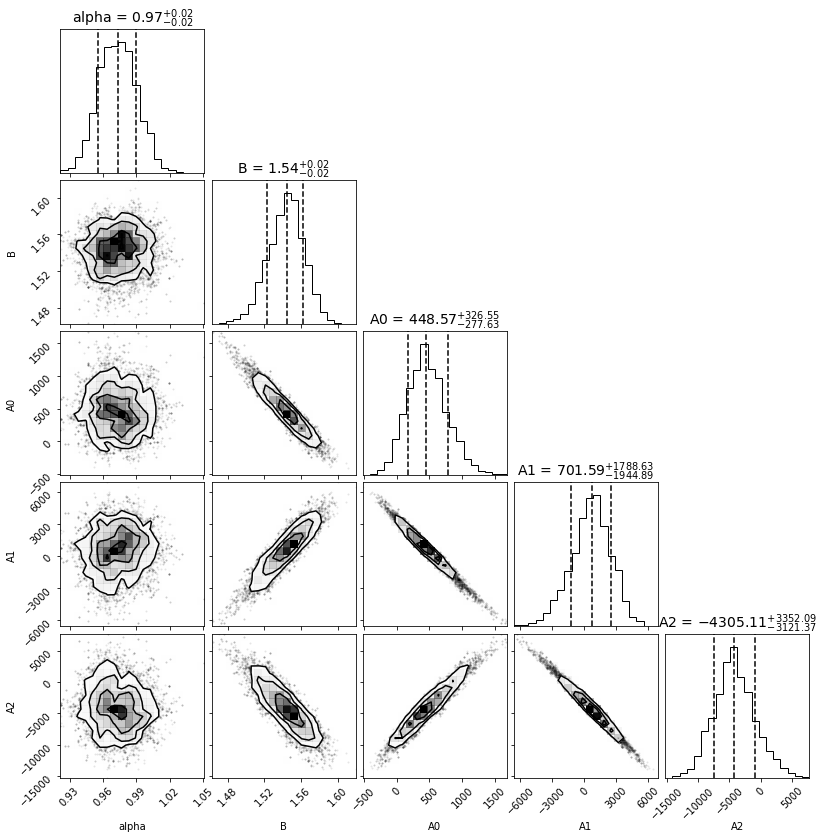

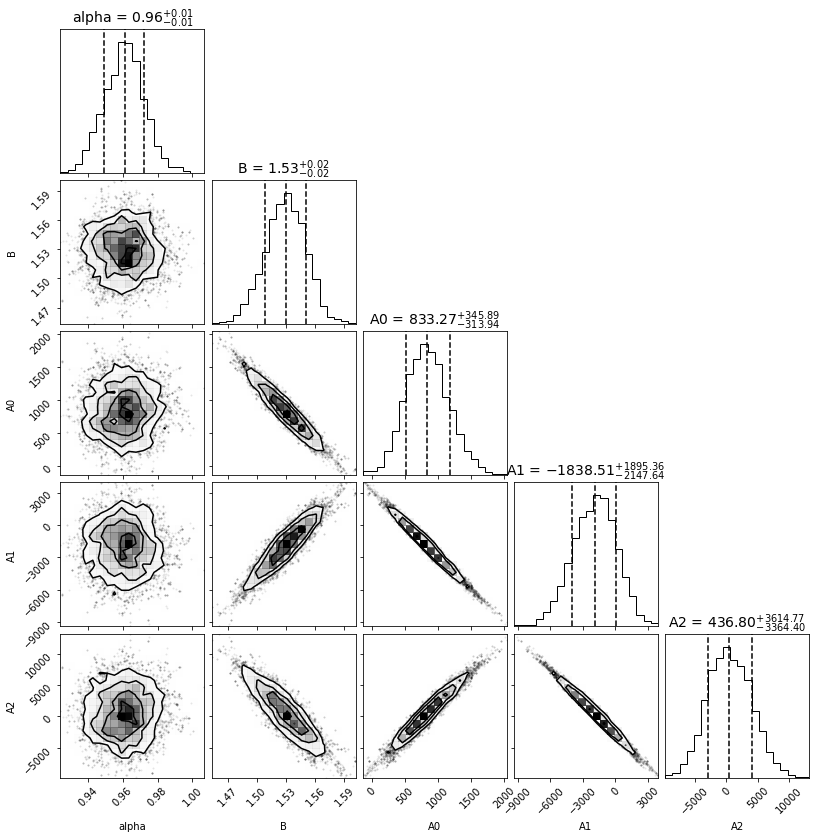

In [7]:
import emcee   # pip install emcee
import corner  # pip install corner

nsteps = 4000
ndim = len(bounds)
nwalkers = 2 * ndim
list_alpha_mean, list_alpha_covariance = [], []
rng = np.random.RandomState(seed=42)

for m in list_data:

    covariance = m.cov
    invcovariance = np.linalg.inv(covariance)
    k = m.x
    data = m.y[0]
    
    def chi2(args):
        model = pk_iso(k, *args)
        diff = data - model
        toret = diff.T.dot(invcovariance).dot(diff)
        return toret
    
    def logprior(args):
        for x, b in zip(args, bounds):
            if not (x > b[0]) & (x < b[1]):
                return -np.inf
        return 0.
    
    def logposterior(args):
        tmp = logprior(args)
        if not np.isfinite(tmp): return tmp
        return -1. / 2. * chi2(args) + tmp
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    start = [[rng.normal(v, (b[1] - b[0]) / 10.) for v, b in zip(init, bounds)] for i in range(nwalkers)]
    sampler.run_mcmc(start, nsteps)
    samples = sampler.get_chain(flat=True)
    # Look at samples, remove burnin
    samples = samples[len(samples) * 3 // 4:]
    # Take mean (or median) and covariance of samples
    mean = np.median(samples[:, 0])
    covariance = np.cov(samples[:, 0])
    list_alpha_mean.append(mean)
    list_alpha_covariance.append(covariance)
    labels = ['alpha','B'] + ['A{:d}'.format(i) for i in range(nbb)]
    fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 14})
    plt.show()
    plt.close(fig)

### Expansion history
The measured $\alpha$ can be modelled by $\alpha_{\mathrm{theory}}(z) = \left[D_{V}(z_{\mathrm{eff}})/r_{\mathrm{drag}}\right] / \left[D_{V}^{\mathrm{fid}}(z_{\mathrm{eff}})/r_{\mathrm{drag}}^{\mathrm{fid}}\right]$ (why?)  
$D_{V}(z) = z^{1/3} D_{M}(z)^{2/3} D_{H}(z)^{1/3}$ with $D_{M}(z)$ comoving transverse distance, $D_{H}(z) = c/H(z)$ "Hubble distance".

Code up $D_{M}(z)$, $D_{H}(z)$ as a function of $\Omega_{m}$ and $\Omega_{k}$ (faster than creating a new cosmology at each MCMC step).  
Build the $\chi^{2}$ of the previously measured $\alpha$, using $\alpha_{\mathrm{theory}}$ as a model.
Previously measured $\alpha$ `list_alpha_mean` should be considered independent (zero cross-correlations); hence the covariance matrix is diagonal, with `list_alpha_covariance` as diagonal elements.
This $\chi^{2}$ depends on $r_{\mathrm{drag}}$ (in $\mathrm{Mpc}/h$), $\Omega_{m}$ and $\Omega_{k}$ if free curvature (entering $D_{M}$ and $D_{H}$).

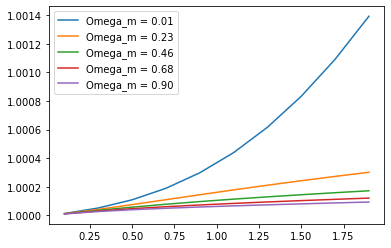

In [8]:
list_z, list_dv_over_rs_fid = [], []
for data in list_data:
    z = data.attrs['zeff']
    list_z.append(z)
    # Precompute DV_fid / rs_drag_fid
    dv = z**(1. / 3.) * ((1 + z) * cosmo_fid.angular_diameter_distance(z))**(2. / 3.) * (100. * cosmo_fid.efunc(z))**(-1. / 3.) / cosmo_fid.rs_drag
    list_dv_over_rs_fid.append(dv)

list_z = np.array(list_z)
list_dv_over_rs_fid = np.array(list_dv_over_rs_fid)

# Define Hubble parameter, comoving angular distance, spherically-averaged distance DV
# model, function of (rs_drag, Omega_m, Omega_k), is DV/rs_drag / (DV_fid / rs_drag_fid) at each data z.

from scipy import integrate, constants

def efunc(z, Omega_m=0.3, Omega_k=0.):
    Omega_lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m*(1 + z)**3 + Omega_k*(1 + z)**2 + Omega_lambda)

def hubble(z, *args, **kwargs):
    return 100. * efunc(z,*args,**kwargs)

def comoving_angular_distance(z, Omega_m=0.3, Omega_k=0.):
    
    def fun(z):
        return 1./efunc(z, Omega_m=Omega_m, Omega_k=Omega_k)

    dc = integrate.quad(fun, 0, z)[0]
    if Omega_k == 0:
        dm = dc
    elif Omega_k < 0:
        dm = np.sin((-Omega_k)**0.5 * dc) / (-Omega_k)**0.5
    else:
        dm = np.sinh(Omega_k**0.5 * dc) / Omega_k**0.5
    return constants.c / 1e3 / 100. * dm

def spherically_averaged_distance(z, *args):
    return z**(1./3.) * comoving_angular_distance(z, *args)**(2. / 3.) * hubble(z, *args)**(-1. / 3.)

def list_alpha_model(rs, *args):
    return np.array([spherically_averaged_distance(z, *args) for z in list_z]) / rs / list_dv_over_rs_fid


# Check predictions: O(1e-4) accuracy, residual comes from neglected radiation
for Omega_m in np.linspace(0.01, 0.9, 5):
    cosmo = cosmo_fid.clone(Omega_m=Omega_m)
    ref = list_z**(1. / 3.) * ((1 + list_z) * cosmo.angular_diameter_distance(list_z))**(2. / 3.) * (100. * cosmo.efunc(list_z))**(-1. / 3.)
    plt.plot(list_z, [spherically_averaged_distance(z, Omega_m) for z in list_z] / ref, label='Omega_m = {:.2f}'.format(Omega_m))
plt.legend()
plt.show()


Use a very wide prior on $r_{\mathrm{drag}}$ as we don't want to make any assumption about the primordial Universe: we only assume constant comoving $r_{\mathrm{drag}}$ ("standard ruler") to constrain expansion history.
Sample the posterior and draw the contours $\Omega_{m} - \Omega_{k}$. See? we detect dark energy! (and zero curvature)

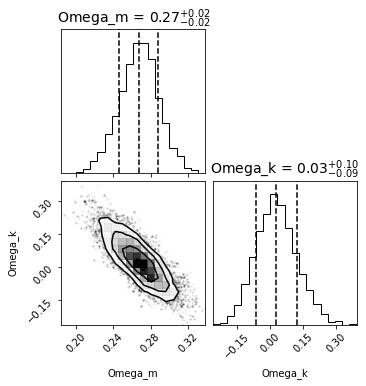

In [9]:
def chi2(args):
    """Write chi2, assuming independent measurements at each redshift."""
    toret = 0.
    for data_alpha, cov, model_alpha in zip(list_alpha_mean, list_alpha_covariance, list_alpha_model(*args)):
        toret += (data_alpha - model_alpha)**2 / cov
    return toret

init = [100., 0.3, 0.]  # rs_drag, Omega_m, Omega_k 
bounds = [(20, 400), (0.01, 0.9), (-0.8, 0.8)]

def logprior(args):
    """Write flat prior between bounds"""
    for x, b in zip(args, bounds):
        if not (x > b[0]) & (x < b[1]):
            return -np.inf
    return 0.

def logposterior(args):
    """Write log-posterior"""
    tmp = logprior(args)
    if not np.isfinite(tmp): return tmp
    return -1. / 2. * chi2(args) + tmp

ndim = len(init)
nwalkers = 4 * ndim
nsteps = 2000
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
start = [[rng.normal(v, (b[1] - b[0]) / 40.) for v, b in zip(init, bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start, nsteps)
samples = sampler.get_chain(flat=True)
# Remove burnin and plot
samples = samples[len(samples)//2: , 1:]
labels = ['Omega_m', 'Omega_k']
#samples[:, 1] = 1 - samples[:, 0] - samples[:, 1]
#labels = ['Omega_m', 'Omega_lambda']
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 14})
plt.show()

### Inverse distance ladder
Do the same, but for $r_{\mathrm{drag}}$ use a Gaussian prior $r_{\mathrm{drag}} = 149.47 \pm 0.48 \; \mathrm{Mpc}$.  
Assume zero curvature for this exercise (though you can let it free in general, in addition to different dark energy models --- all those are constrained by BAO).
Sample the posterior and draw the contours $\Omega_{m} - H_{0}$. See? we constrain $H_{0}$!

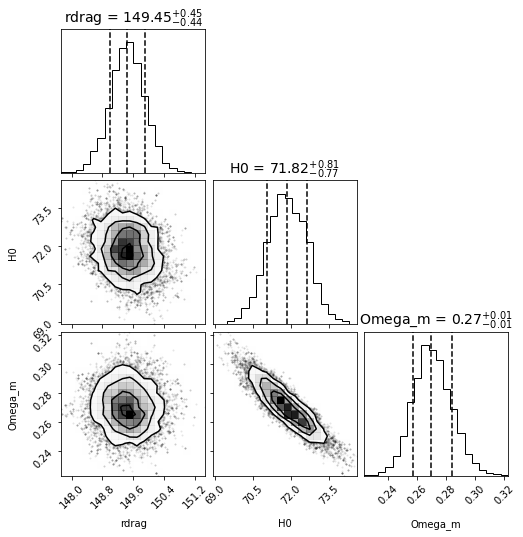

In [10]:
def list_alpha_model(rs, H0, *args):
    return np.array([spherically_averaged_distance(z, *args) for z in list_z]) / (H0 / 100.) / rs / list_dv_over_rs_fid

init = [149.47, 70, 0.3]  # rs_drag, H0, Omega_m 
bounds = [(100, 200), (50, 100), (0.1, 0.5)]

def logprior(args):
    for x,b in zip(args, bounds):
        if not (x > b[0]) & (x < b[1]):
            return -np.inf
    rdrag = args[0]
    return -1. / 2. * (rdrag - 149.47)**2 / 0.48**2

ndim = len(init)
nwalkers = 4 * ndim
nsteps = 3000
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
start = [[rng.normal(v, (b[1] - b[0]) / 10.) for v, b in zip(init, bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start, nsteps)
samples = sampler.get_chain(flat=True)
samples = samples[len(samples) // 2:]
labels = ['rdrag', 'H0', 'Omega_m', 'Omega_k']
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 14})
plt.show()

### BBN prior
CMB constraints provide a measurement of $r_{\mathrm{drag}}$ (through $\omega_{cdm}$ and $\omega_{b}$),
but we only need a prior on $\omega_{b} = \Omega_{b} h^{2}$ since $\Omega_{m}$ is constrained by BAO mesurements.  $\omega_{b} = \Omega_{b} h^{2}$ is constrained by measurements of deuterium abundance as a result of BBN.

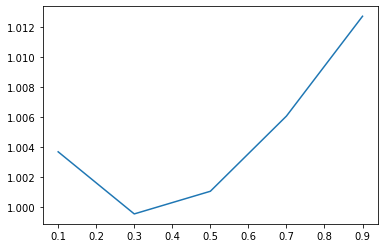

In [11]:
# To compute rs_drag, either:
# 1) use cosmoprimo (engine='class')
def rs_drag(omega_b, omega_m):
    return cosmo_fid.clone(omega_b=omega_b, omega_m=omega_m, engine='class').rs_drag / cosmo_fid.h
# 2) use cosmoprimo (engine='eisentein_hu')
def rs_drag(omega_b, omega_m):
    return cosmo_fid.clone(omega_b=omega_b, omega_m=omega_m, engine='eisenstein_hu').rs_drag / cosmo_fid.h
# 3) implement rs_drag yourself, following https://arxiv.org/abs/astro-ph/9709112, eq. 4 - 6.
# For $z_{\mathrm{drag}}$, rather use https://arxiv.org/abs/astro-ph/9510117, eq. E1 (found better match to Boltzmann code).
# Fix $T_\mathrm{cmb} = 2.7255$ (Cobe-FIRAS).

def rs_drag(omega_b, omega_m):
    T_cmb = 2.7255
    frac_baryon  = omega_b / omega_m
    theta_cmb = T_cmb / 2.7

    # redshift and wavenumber of equality
    # EH eq. 2 & 3
    z_eq = 2.5e4 * omega_m * theta_cmb ** (-4) - 1. # this is z
    k_eq = 0.0746 * omega_m * theta_cmb ** (-2) # units of 1/Mpc

    # sound horizon and k_silk
    # EH eq. 4
    z_drag_b1 = 0.313 * omega_m ** (-0.419) * (1 + 0.607 * omega_m ** 0.674)
    z_drag_b2 = 0.238 * omega_m ** 0.223
    #z_drag = 1291 * omega_m ** 0.251 / (1. + 0.659 * omega_m ** 0.828) * (1. + z_drag_b1 * omega_b ** z_drag_b2)
    # HS1996, arXiv 9510117, eq. E1 actually better match to CLASS
    z_drag = 1345 * omega_m ** 0.251 / (1. + 0.659 * omega_m ** 0.828) * (1. + z_drag_b1 * omega_b ** z_drag_b2)

    # EH eq. 5
    r_drag = 31.5 * omega_b * theta_cmb ** (-4) * (1000. / (1 + z_drag))
    r_eq   = 31.5 * omega_b * theta_cmb ** (-4) * (1000. / (1 + z_eq))

    # EH eq. 6
    return 2. / (3.*k_eq) * np.sqrt(6. / r_eq) * \
           np.log((np.sqrt(1 + r_drag) + np.sqrt(r_drag + r_eq)) / (1 + np.sqrt(r_eq)))

# Check predictions: O(1e-3) accuracy
ref, test = [], []
Omega_m = np.linspace(0.1, 0.9, 5)
for Om in Omega_m:
    cosmo = cosmo_fid.clone(Omega_m=Om)
    ref.append(cosmo.rs_drag / cosmo.h)
    test.append(rs_drag(cosmo_fid.Omega0_b * cosmo_fid.h**2, Om * cosmo_fid.h**2))
r = np.array(test) / np.array(ref)
plt.plot(Omega_m, r)
plt.show()

Redo the previous sampling, varying $H_{0}$, $\Omega_{m}$ and $\omega_{b}$ with the BBN prior: $\omega_{b} = 0.02235 \pm 0.00037$.

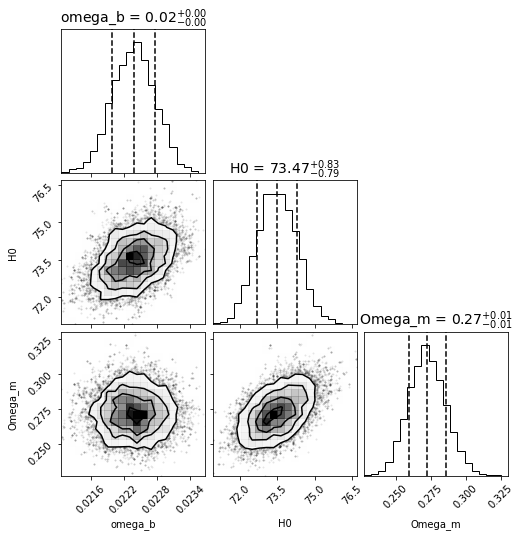

In [12]:
def list_alpha_model(omega_b, H0, Omega_m):
    h = H0 / 100.
    rs = rs_drag(omega_b, Omega_m * h**2)
    return np.array([spherically_averaged_distance(z, Omega_m) for z in list_z]) / h / rs / list_dv_over_rs_fid

init = [0.02235, 70, 0.3]  # omega_b, H0, Omega_m
bounds = [(0.01, 0.03), (50, 100), (0.1, 0.5)]

def logprior(args):
    for x,b in zip(args, bounds):
        if not (x > b[0]) & (x < b[1]):
            return -np.inf
    omega_b = args[0]
    return - 1. / 2. * (omega_b - 0.02235)**2 / 0.00037**2

ndim = len(init)
nwalkers = 4 * ndim
nsteps = 3000
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
start = [[rng.normal(v, (b[1] - b[0]) / 10.) for v, b in zip(init, bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start, nsteps)
samples = sampler.get_chain(flat=True)
samples = samples[len(samples) // 2:]
labels = ['omega_b', 'H0', 'Omega_m']
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 14})
plt.show()

## Take-home messages
- BAO feature is a standard ruler: measuring the position of the BAO peak = measuring a fixed comoving distance (sound horizon at the drag epoch) at a given redshift = constraing the Universe's expansion
- assuming standard ruler only (of unspecified length), we can constrain the 'derivatives of the expansion', i.e. the matter / dark energy density
- with an additional prior on $r_{\mathrm{drag}}$ (or $\omega_{b}$), we can measure $H_{0}$ = 'inverse distance ladder'

## Bonus
- see how $\Omega_{m} - H_{0}$ contour rotates with redshift
- perform fits on real eBOSS data (see eBOSS_LRGpCMASS.ipynb for power spectrum measurements): isotropic, anisotropic BAO fits, RSD fits, ...
- why are you still here? go to the beach...

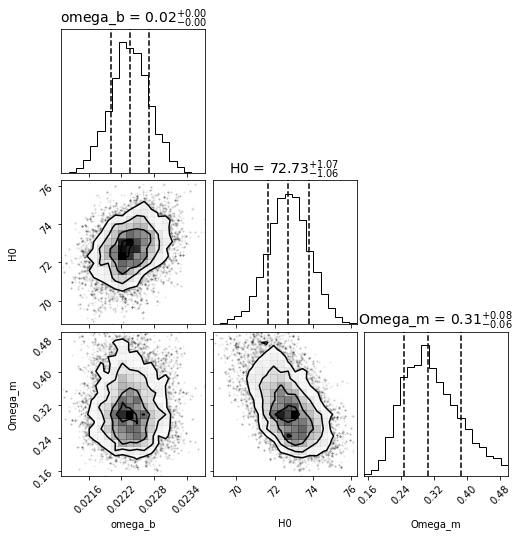

In [13]:
def chi2(args):
    toret = 0.
    for z, data_alpha, cov, model_alpha in zip(list_z, list_alpha_mean, list_alpha_covariance, list_alpha_model(*args)):
        if z > 1.: 
            toret += (data_alpha - model_alpha)**2 / cov
    return toret

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
start = [[rng.normal(v, (b[1] - b[0]) / 10.) for v, b in zip(init, bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start, nsteps)
samples = sampler.get_chain(flat=True)
samples = samples[len(samples) // 2:]
labels = ['omega_b', 'H0', 'Omega_m']
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 14})
plt.show()

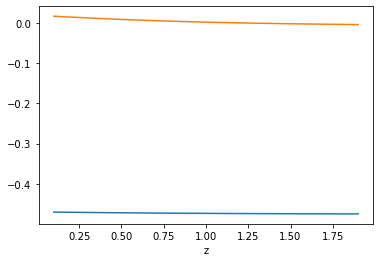

[[2.09221462e+04 2.64691609e+02]
 [2.64691609e+02 4.24121172e+00]]
[[8291.51484204 -349.03908299]
 [-349.03908299   30.97296901]]


In [14]:
def get_deriv(i=1, dx=1e-3):
    xp, xm = init.copy(), init.copy()
    xp[i] += dx
    xm[i] -= dx 
    return (list_alpha_model(*xp) - list_alpha_model(*xm)) / (2*dx)

deriv_H0 = get_deriv(1)
deriv_Omega_m = get_deriv(2)
plt.plot(list_z, deriv_H0 * init[1])
plt.plot(list_z, deriv_Omega_m * init[0])
plt.xlabel('z')
plt.show()

deriv_model = np.array([deriv_H0, deriv_Omega_m])[:, list_z<1]
invfisher = deriv_model.dot(deriv_model.T)
print(np.linalg.inv(invfisher))

deriv_model = np.array([deriv_H0, deriv_Omega_m])[:, list_z>1]
invfisher = deriv_model.dot(deriv_model.T)
print(np.linalg.inv(invfisher))